In [82]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

import xlrd

In [83]:
df = pd.read_excel('C:\\Users\\kenne\\Desktop\\table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls', header=4)

# print(df.columns)

# df.head(3)

In [84]:
df.drop(df[(df.Robbery > 2500)].index, inplace=True)
df.drop(df[(df.Population > 2000000)].index, inplace=True)

In [85]:
df['Pop_Sqrd'] = df['Population'] ** 2
df['Murder_Cat'] = df['Murder and\nnonnegligent\nmanslaughter'].dropna().map(lambda x: 1 if x > 0 else 0)
df['Robbery_Cat'] = df.Robbery.dropna().map(lambda x: 1 if x > 0 else 0)
df['Property_Crime'] = df['Property\ncrime']

df.head(3)

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Pop_Sqrd,Murder_Cat,Robbery_Cat,Property_Crime
0,Adams Village,1861.000,0.000,0.000,nan,0.000,0.000,0.000,12.000,2.000,10.000,0.000,0.000,3463321.000,0.000,0.000,12.000
1,Addison Town and Village,2577.000,3.000,0.000,nan,0.000,0.000,3.000,24.000,3.000,20.000,1.000,0.000,6640929.000,0.000,0.000,24.000
2,Akron Village,2846.000,3.000,0.000,nan,0.000,0.000,3.000,16.000,1.000,15.000,0.000,0.000,8099716.000,0.000,0.000,16.000


In [86]:
data_rdy = df[['Population', 'Pop_Sqrd', 'Murder_Cat', 'Robbery_Cat', 'Property_Crime']].dropna()

data_rdy.describe()

,Population,Pop_Sqrd,Murder_Cat,Robbery_Cat,Property_Crime
count,347.000,347.000,347.000,347.000,347.000
mean,15956.686,985840709.758,0.138,0.599,385.752
std,27080.219,5067232380.434,0.346,0.491,1034.369
min,526.000,276676.000,0.000,0.000,0.000
25%,2997.000,8982153.000,0.000,0.000,40.000
50%,7187.000,51652969.000,0.000,1.000,112.000
75%,18160.500,329804222.500,0.000,1.000,340.500
max,258789.000,66971746521.000,1.000,1.000,12491.000


In [87]:
#Instantiate and fit the model
regr = linear_model.LinearRegression()
Y = data_rdy['Property_Crime']
X = data_rdy[['Population', 'Pop_Sqrd', 'Murder_Cat', 'Robbery_Cat']]
regr.fit(X, Y)

#inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared: \n')
print(regr.score(X, Y))


Coefficients: 
 [1.29510871e-02 1.14920528e-07 1.95038666e+02 9.28205845e+01]

Intercept: 
 -16.815866321663066

R-squared: 

0.8444937611173492


The model where the outcome Property Crime is predicted by the features Population, Population Squared, Murder Category and Robbery Category explains 84.45% of the variance in Property Crime.

*************************  Everything above from original model  ****************************

In [88]:
# Using Holdout Groups.
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

# Use train_test_split to create the necessary training and test groups.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=20)

print('With 25% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(X, Y).score(X, Y)))

With 25% Holdout: 0.022988505747126436
Testing on Sample: 0.02881844380403458


In [89]:
# Using Cross Validation.
from sklearn import cross_validation
from sklearn import model_selection
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Use train_test_split to create the necessary training and test groups.
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.25, random_state=20)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
accuracy = regr.score(X_test, y_test)
print('Accuracy of Test Data:', accuracy)

scores = model_selection.cross_val_score(regr, X_train, y_train, cv=3)
print('Cross Validation Scores:', scores)

Accuracy of Test Data: 0.832811055814184
Cross Validation Scores: [0.59764685 0.90600953 0.6613675 ]


In [90]:
# Writing out the model formula.
# Dependent variable on the right, independent variables on the left.
# Using a ~ to represent an '=' from the functional form.
linear_formula = 'Property_Crime ~ Population+Pop_Sqrd+Murder_Cat+Robbery_Cat'

# Fitting model to our data usign the formula.
lm = smf.ols(formula=linear_formula, data=data_rdy).fit()

In [91]:
# Looking at the coefficients of our model.
lm.params

Intercept     -16.816
Population      0.013
Pop_Sqrd        0.000
Murder_Cat    195.039
Robbery_Cat    92.821
dtype: float64

In [92]:
# Looking at the p-values as a significance test for each of the coefficients above.
lm.pvalues

Intercept     0.641
Population    0.000
Pop_Sqrd      0.000
Murder_Cat    0.011
Robbery_Cat   0.072
dtype: float64

In [93]:
# Looking at r-squared.
lm.rsquared

0.8444937611173492

Population Squared has a coefficient score of zero and a p-value score of zero as well. I will remove this feature from the model since it appears there is no effect.

In [94]:
linear_formula = 'Property_Crime ~ Population+Murder_Cat+Robbery_Cat'

lm = smf.ols(formula=linear_formula, data=data_rdy).fit()

In [95]:
lm.params

Intercept     -108.423
Population       0.034
Murder_Cat      14.347
Robbery_Cat    -94.252
dtype: float64

In [96]:
lm.pvalues

Intercept     0.008
Population    0.000
Murder_Cat    0.869
Robbery_Cat   0.096
dtype: float64

In [97]:
lm.rsquared

0.7889428000907827

Removing Population Squared actually reduced the r-squared score. I am going to try removing both Population features to view the impact on r-squared.

In [98]:
linear_formula = 'Property_Crime ~ Murder_Cat+Robbery_Cat'

lm = smf.ols(formula=linear_formula, data=data_rdy).fit()

In [99]:
lm.params

Intercept       40.100
Murder_Cat    1194.064
Robbery_Cat    301.087
dtype: float64

In [100]:
lm.pvalues

Intercept     0.607
Murder_Cat    0.000
Robbery_Cat   0.005
dtype: float64

In [101]:
lm.rsquared

0.21510604824907786

Removing both Population features significantly reduces our r-square score. As a last trial, I am going to only include the Population and Robbery Category features.

In [102]:
linear_formula = 'Property_Crime ~ Population+Robbery_Cat'

lm = smf.ols(formula=linear_formula, data=data_rdy).fit()

In [103]:
lm.params

Intercept     -108.696
Population       0.034
Robbery_Cat    -92.676
dtype: float64

In [104]:
lm.pvalues

Intercept     0.008
Population    0.000
Robbery_Cat   0.097
dtype: float64

In [105]:
lm.rsquared

0.7889261062753921

The model with all features produces the highest r-squared score.

In [110]:
# Using 2014 data to validate the model.
df_2014 = pd.read_excel('C:\\Users\\kenne\\Desktop\\Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls', header=4)

# df_2014.head(3)

In [109]:
df_2014.describe()

,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
count,369.000,369.000,369.000,227.000,142.000,369.000,369.000,368.000,369.000,368.000,369.000,365.000
mean,37814.824,183.691,1.453,15.555,0.007,60.661,112.005,698.361,100.900,562.791,34.317,1.425
std,441159.058,2638.842,17.694,146.261,0.084,866.481,1640.515,7123.614,855.103,5869.850,406.957,7.995
min,79.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2631.000,1.000,0.000,0.000,0.000,0.000,0.000,25.000,4.000,20.000,0.000,0.000
50%,6581.000,5.000,0.000,1.000,0.000,1.000,3.000,76.000,12.000,60.500,2.000,0.000
75%,15408.000,18.000,0.000,4.000,0.000,4.000,12.000,271.500,39.000,228.500,6.000,1.000
max,8473938.000,50564.000,333.000,2190.000,1.000,16581.000,31460.000,135747.000,15916.000,112107.000,7724.000,135.000


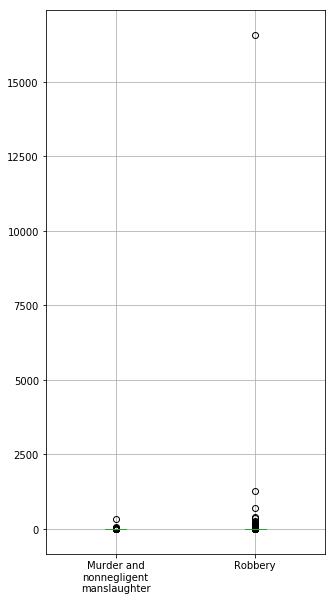

In [112]:
# Using same steps as with 2013 file to set-up file for use in our model.

plt.figure(figsize=(5, 10))
df_2014.boxplot(column=['Murder and\nnonnegligent\nmanslaughter', 'Robbery'])
plt.show()

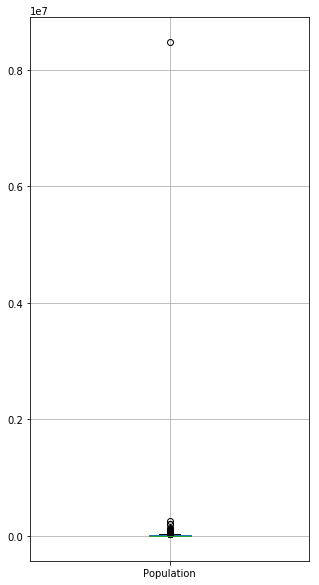

In [113]:
plt.figure(figsize=(5, 10))
df_2014.boxplot(column=['Population'])
plt.show()

In [116]:
df_2014.drop(df_2014[(df_2014.Robbery > 2500)].index, inplace=True)
df_2014.drop(df_2014[(df_2014.Population > 2000000)].index, inplace=True)

In [117]:
df_2014['Pop_Sqrd'] = df_2014['Population'] ** 2
df_2014['Murder_Cat'] = df_2014['Murder and\nnonnegligent\nmanslaughter'].dropna().map(lambda x: 1 if x > 0 else 0)
df_2014['Robbery_Cat'] = df_2014.Robbery.dropna().map(lambda x: 1 if x > 0 else 0)
df_2014['Property_Crime'] = df_2014['Property\ncrime']

df_2014.head(3)

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Pop_Sqrd,Murder_Cat,Robbery_Cat,Property_Crime
0,Adams Village,1851.000,0.000,0.000,nan,0.000,0.000,0.000,11.000,1.000,10.000,0.000,0.000,3426201.000,0.000,0.000,11.000
1,Addison Town and Village,2568.000,2.000,0.000,nan,0.000,1.000,1.000,49.000,1.000,47.000,1.000,0.000,6594624.000,0.000,1.000,49.000
2,Afton Village4,820.000,0.000,0.000,0.000,nan,0.000,0.000,1.000,0.000,1.000,0.000,0.000,672400.000,0.000,0.000,1.000


In [118]:
data_rdy2 = df_2014[['Population', 'Pop_Sqrd', 'Murder_Cat', 'Robbery_Cat', 'Property_Crime']].dropna()

data_rdy2.describe()

,Population,Pop_Sqrd,Murder_Cat,Robbery_Cat,Property_Crime
count,367.000,367.000,367.000,367.000,367.000
mean,14901.888,927952566.395,0.136,0.529,330.381
std,26604.792,4943336598.451,0.344,0.500,958.006
min,79.000,6241.000,0.000,0.000,0.000
25%,2625.500,6893280.500,0.000,0.000,25.000
50%,6548.000,42876304.000,0.000,1.000,75.000
75%,15325.000,234862514.000,0.000,1.000,269.000
max,258419.000,66780379561.000,1.000,1.000,12449.000


In [119]:
#Instantiate and fit the model
regr = linear_model.LinearRegression()
Y = data_rdy2['Property_Crime']
X = data_rdy2[['Population', 'Pop_Sqrd', 'Murder_Cat', 'Robbery_Cat']]
regr.fit(X, Y)

#inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared: \n')
print(regr.score(X, Y))


Coefficients: 
 [9.51829747e-03 1.18331259e-07 2.77208015e+02 9.86630673e+01]

Intercept: 
 -11.186008254707986

R-squared: 

0.8399435640661663


In [120]:
# Writing out the model formula.
# Dependent variable on the right, independent variables on the left.
# Using a ~ to represent an '=' from the functional form.
linear_formula = 'Property_Crime ~ Population+Pop_Sqrd+Murder_Cat+Robbery_Cat'

# Fitting model to our data usign the formula.
lm = smf.ols(formula=linear_formula, data=data_rdy2).fit()

In [121]:
lm.params

Intercept     -11.186
Population      0.010
Pop_Sqrd        0.000
Murder_Cat    277.208
Robbery_Cat    98.663
dtype: float64

In [122]:
lm.pvalues

Intercept     0.713
Population    0.000
Pop_Sqrd      0.000
Murder_Cat    0.000
Robbery_Cat   0.038
dtype: float64

In [123]:
lm.rsquared

0.8399435640661663

Based on this new data, the original linear regression model with the full set of features predicts property crime slightly better than 2014.